## Лабораторная работа № 2

У нас есть медицинские данные людей, у которых определено наличие или отсутствие заболевания (столбец status).

**Задание**: 
- Проанализировать данные (EDA)
- Предобработать данные
- Скалировать/нормализовать данные
- Подготовить данные для обучения моделей
- Решить задачу бинарной классификации
- Попробовать несколько моделей для решения этой задачи, оценить точность каждой
- Получить значение accuracy больше 95%, построить матрицу путаницы и roc-кривую
- Сделать выводы


#### 1) Считаем данные: 

In [105]:
import pandas as pd

data = pd.read_csv('data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

#### 2) Гистограммы 

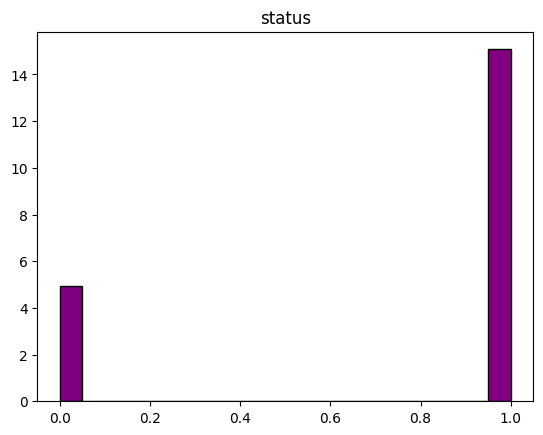

In [106]:
import matplotlib.pyplot as plt

plt.hist(data['status'], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('status')
plt.show()

Обычно здоровых людей больше, чем больных. По гистограмме видно, что значений status, равных 1, больше, чем 0, из чего следует, что значение status = 1 - человек здоров, а 0 - человек болен.

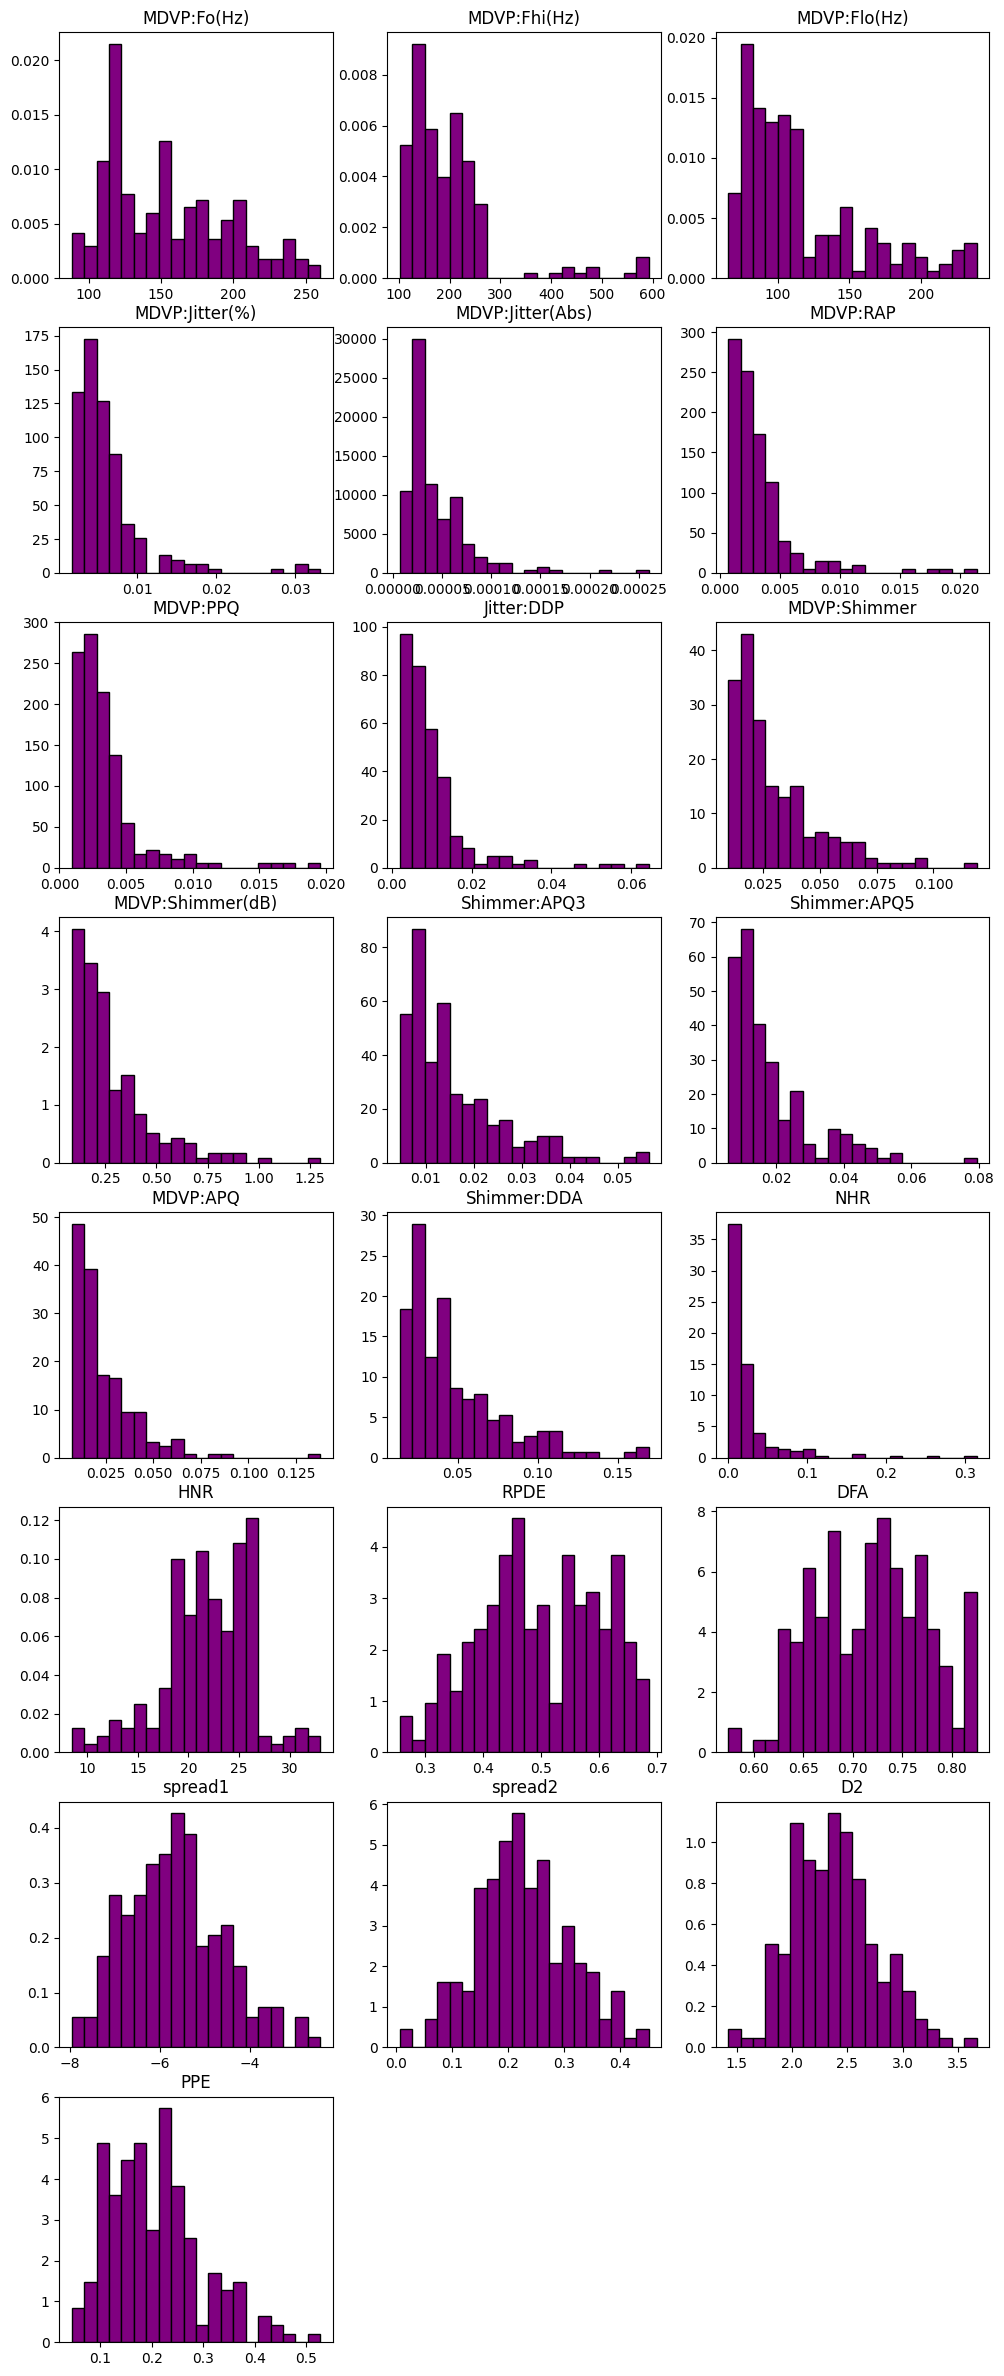

In [107]:
plt.figure(figsize=(12,30))
i = 1
for column in data.columns:
    if column != 'name' and column != 'status':
        plt.subplot(8, 3, i)
        plt.hist(data[column], density=True, color = 'purple', edgecolor = 'black', bins=20)
        plt.title(column)
        i += 1
plt.show()

По гистограммам видно, что многие признаки имеют распределение, похожее на логнормальное или нормальное распределения. Так же можно заметить, что почти все признаки имеют выбросы (в этом можно также убедиться, посмотрев на их ящики с усами, что будет сделано ниже). Поскольку мы не знаем природу возникновения этих выбросов, оставим все как есть.

#### 3) Тепловая карта 

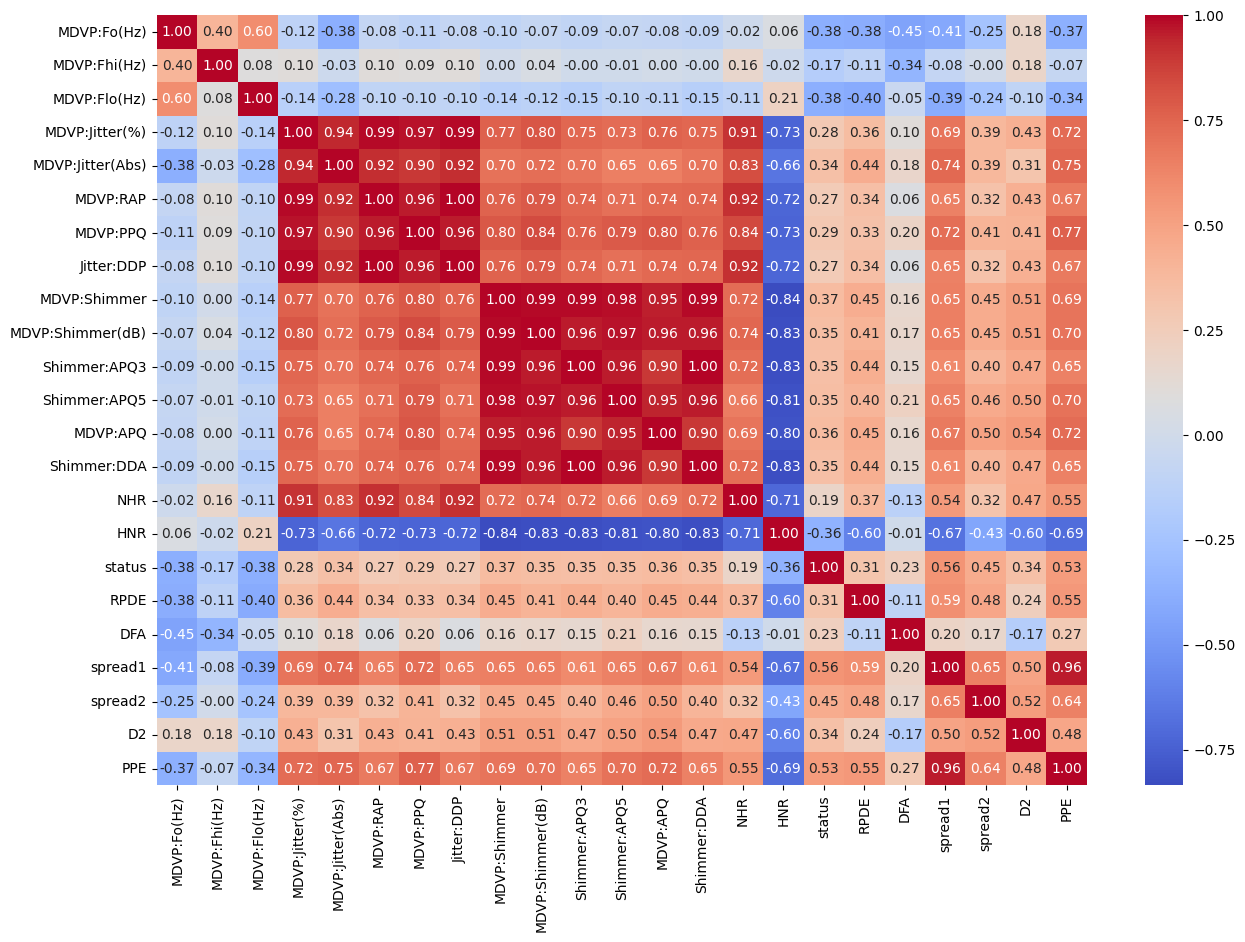

In [35]:
import seaborn as sns


corr_matrix = data.loc[:, data.columns != 'name'].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

По тепловой карте видно, что некоторые признаки сильно коррелированы между собой, например, признаки, идущие с MDVP:Jitter(%) по HNR в таблице. К тому же можно заметить, что целевая переменная status имеет сильную корреляцию не со всеми признаками. Она сильно коррелирована только с признаками spread1 и PPE.  

#### 4) Выбросы

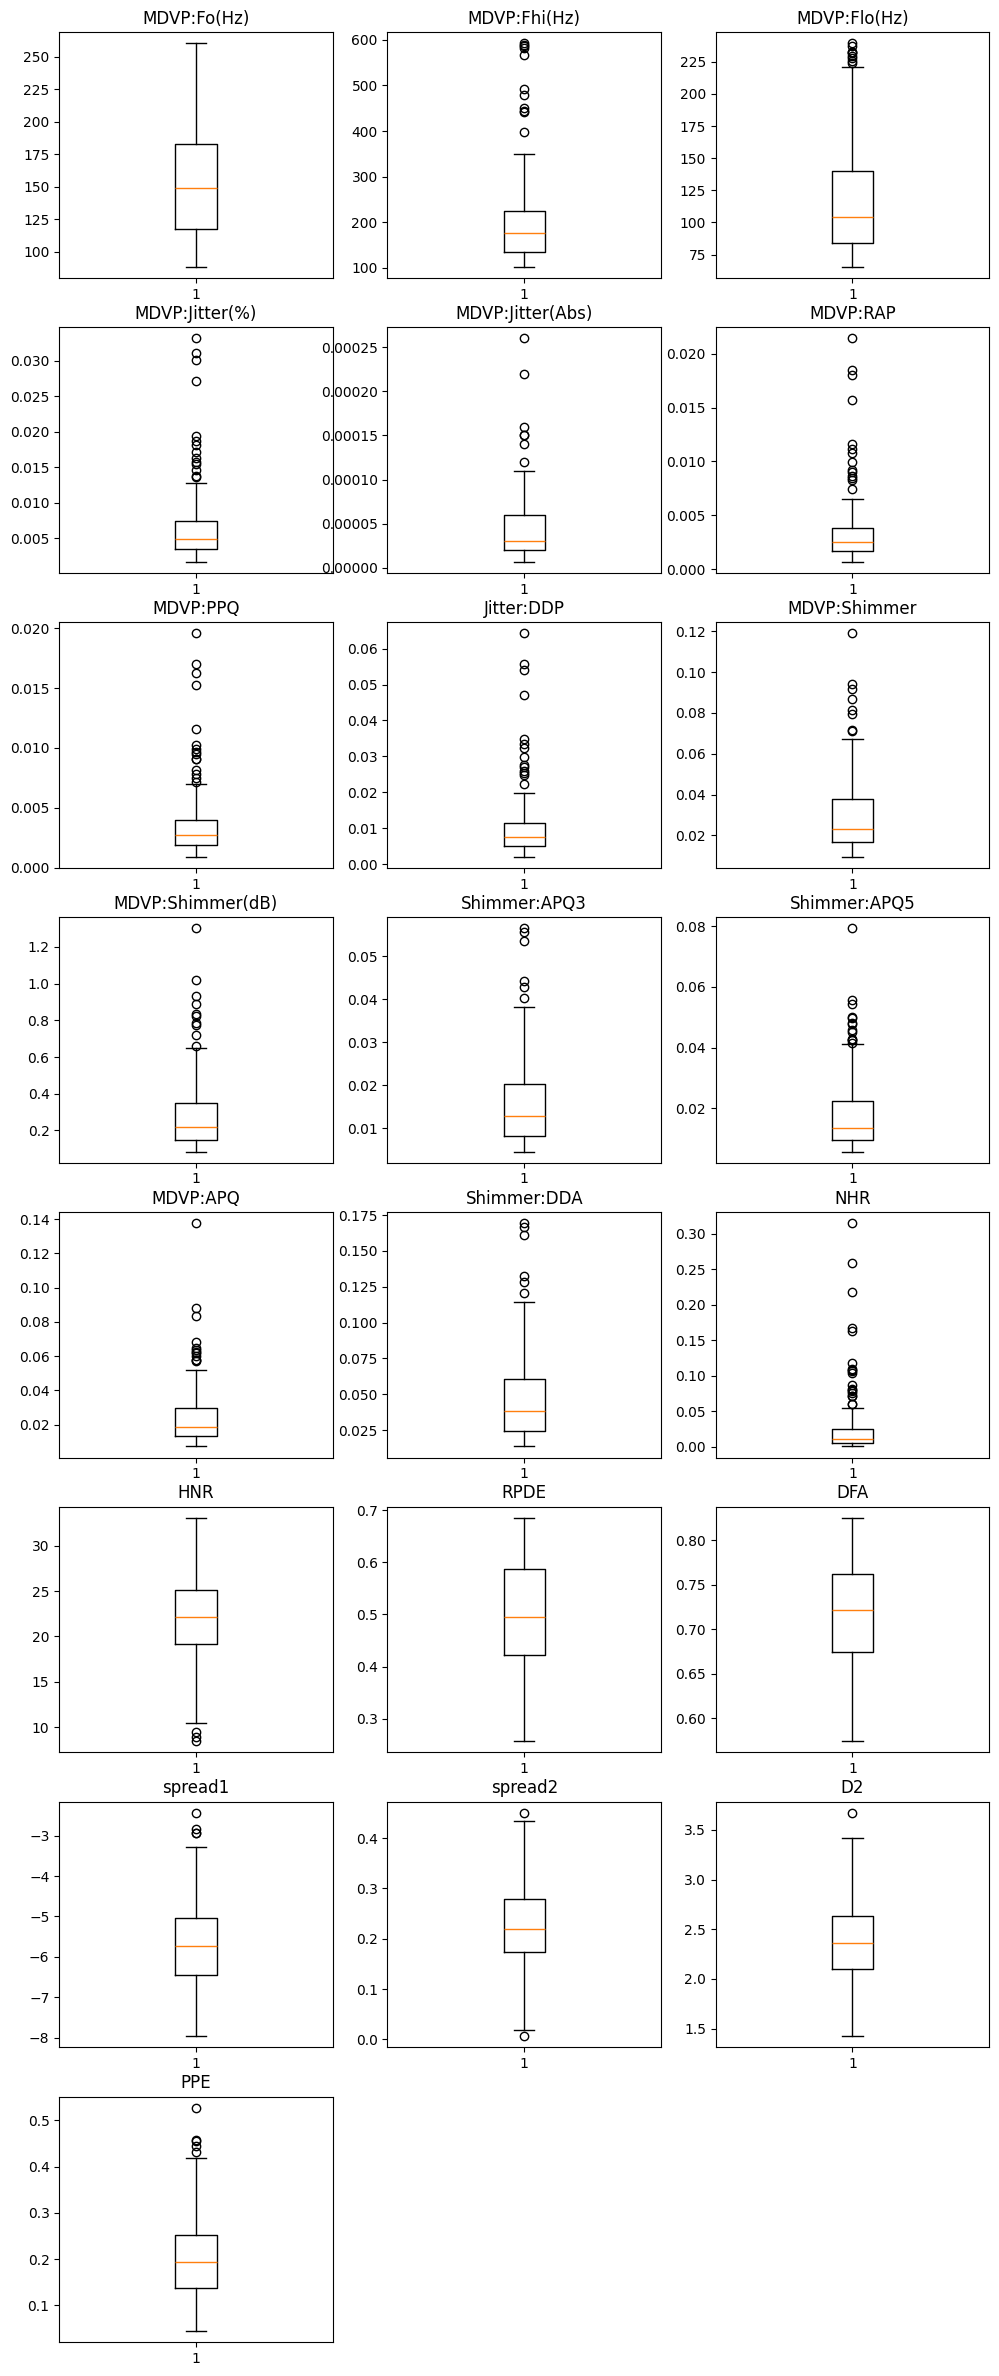

In [108]:
plt.figure(figsize=(12,30))
i = 1
for column in data.columns:
    if column != 'name' and column != 'status':
        plt.subplot(8, 3, i)
        plt.boxplot(data[column])
        plt.title(column)
        i += 1
plt.show()

Построив ящики с усами, можно убедиться в том, что почти все признаки имеют выбросы. 

#### 5) Нормализация 

In [109]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_normalize = data.columns.tolist()
columns_to_normalize.remove('name')
columns_to_normalize.remove('status')

data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

#### 6) Логистическая регрессия 

In [129]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = data.drop(['status', 'name', 'MDVP:Fhi(Hz)', 'NHR', 'DFA'], axis=1).to_numpy()
y = data['status'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность: {accuracy}")

Точность: 0.8974358974358975


#### 7) Дерево решений 

In [146]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy', max_depth=3) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность: {accuracy}")


Точность: 0.9487179487179487


#### 8) Бэггинг

In [156]:
from sklearn.ensemble import BaggingClassifier

base_classifier = DecisionTreeClassifier()

bagging_classifier = BaggingClassifier(
    estimator=base_classifier,
    n_estimators=10,  # Количество деревьев
    max_samples=0.8,   # Доля объектов в каждой подвыборке
    max_features=0.8   # Доля признаков, используемых для обучения каждого дерева
)

bagging_classifier.fit(X_train, y_train)

y_pred_bagg = bagging_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_bagg)
print(f"Точность: {accuracy}")

Точность: 0.9743589743589743


#### 9) Случайный лес 

In [159]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(
    n_estimators=10,
    max_depth=None, # Максимальная глубина дерева
    min_samples_split=2, # Минимальное количество объектов для разбиения узла
    min_samples_leaf=1
)

rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Точность: {accuracy}")

Точность: 0.9743589743589743


#### 10) Бустинг 

In [163]:
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_depth=3
)

gb_classifier.fit(X_train, y_train)

y_pred_gb = gb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Точность: {accuracy}")

Точность: 0.9743589743589743


#### 11) Метод k-ближайших соседей

In [178]:
from sklearn.neighbors import KNeighborsClassifier

k = 3  
model = KNeighborsClassifier(n_neighbors=k, weights='distance')
model.fit(X_train, y_train)

y_pred_kn = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_kn)
print(f"Точность: {accuracy}")

Точность: 0.9743589743589743


Таким образом, значение accuracy, большее 95%, удалось получить с помощью бэггинга, случайного леса, бустинга и метода k-ближайших соседей. 

#### 12) Матрица путаницы

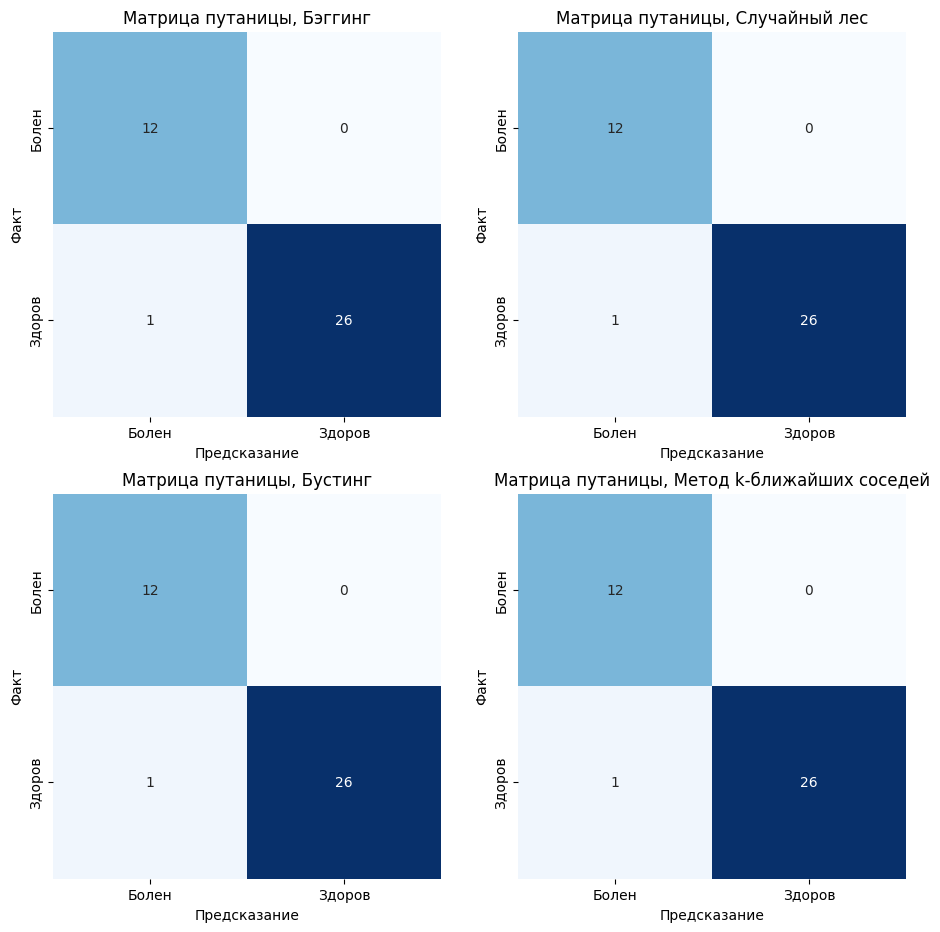

TP: 12
FN: 0
FP: 1
TN: 26


In [176]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(11,11))

plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred_bagg, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Болен", "Здоров"],
            yticklabels=["Болен", "Здоров"])
plt.xlabel("Предсказание")
plt.ylabel("Факт")
plt.title("Матрица путаницы, Бэггинг")

plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Болен", "Здоров"],
            yticklabels=["Болен", "Здоров"])
plt.xlabel("Предсказание")
plt.ylabel("Факт")
plt.title("Матрица путаницы, Случайный лес")

plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, y_pred_gb, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Болен", "Здоров"],
            yticklabels=["Болен", "Здоров"])
plt.xlabel("Предсказание")
plt.ylabel("Факт")
plt.title("Матрица путаницы, Бустинг")

plt.subplot(2, 2, 4)
cm = confusion_matrix(y_test, y_pred_kn, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Болен", "Здоров"],
            yticklabels=["Болен", "Здоров"])
plt.xlabel("Предсказание")
plt.ylabel("Факт")
plt.title("Матрица путаницы, Метод k-ближайших соседей")

plt.show()

TP, FN, FP, TN = confusion_matrix(y_test, y_pred_rf).ravel()

print("TP:", TP)
print("FN:", FN)
print("FP:", FP)
print("TN:", TN)

Как можно видеть, матрицы путаницы для лучших методов полностью совпадают. Модели не пропустили ни одного больного человека и только одному здоровому человеку поставили диагноз, что является очень хорошим показателем. 

#### 13) Метрики для оценки модели 

In [177]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP) 
F1 = 2 * (precision * recall) / (precision + recall)

print('precision = ', round(precision, 2))
print('recall = ', round(recall, 2))
print('specificity = ', round(specificity, 2))
print('F1 = ', round(F1, 2))

precision =  0.92
recall =  1.0
specificity =  0.96
F1 =  0.96


Значения метрик довольно высоки, что говорит о хорошем качестве всех лучших моделей. 
Самой важной метрикой в этой задаче является recall, поскольку нам важно не пропустить болного человека. Значение recall равно 1, что является очень хорошим результатом. 

#### 14) Roc-кривая

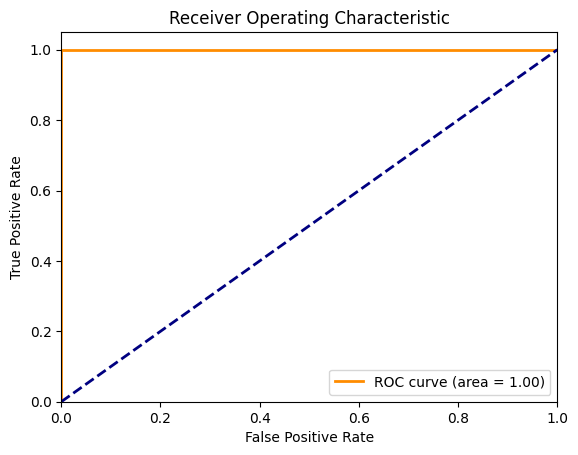

AUC: 1.0
AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # Случайная модель
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc}")

Получившаяся roc-кривая отражает идеальную производительность модели. Значение AUC, равное 1, указывает на идеальную классификацию. 

#### 15) Выводы 

Таким образом, в данной работе удалось добиться значения accuracy, большее 95%, с помощью 4 методов - бэггинга, случайного леса, бустинга и метода k-ближайших соседей. Значение recall этих методов, наиболее важной метрики для данной задачи, равно 1, что говорит о высокой точности моделей. 
Roc-кривая и значение AUC, равное 1, также отражают идеальную производительность моделей. 